In [6]:
# 📦 导入依赖
import ROOT
import uproot
import math
import numpy as np
import awkward as ak
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy.stats import gamma as gamma_dist
from scipy.stats import lognorm as log_normal_dist
from scipy.stats import norm as gaussian_dist
from scipy.stats import binned_statistic
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from scipy.interpolate import UnivariateSpline
import pandas as pd
import os
import gc
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
plt.style.use('/home/llr/ilc/shi/code/Plot_style/cepc.mplstyle')
fig_size = (8, 6)
# 🔧 解码函数：根据 bitfield <id>calolayer:7,abslayer:1,cellid:13</id>
def decode_volid(volid):
    volid = int(volid)
    calolayer = volid & 0x7F                 # bits 0–6
    abslayer  = (volid >> 7) & 0x1           # bit 7
    cellid    = (volid >> 8) & 0x1FFF        # bits 8–20
    return calolayer, abslayer, cellid

# 🧮 从 cellid 解出 index_x/y/z（若 cellid = z*1600 + y*40 + x）
def decode_indices(cellid):
    index_z = cellid // 1600
    index_y = (cellid % 1600) // 40
    index_x = cellid % 40
    return index_x, index_y, index_z
def exp_func(x, a, b, c):
    return a * np.exp(b * x) + c

In [7]:
# 打开 ROOT 文件，载入 events tree
Threshold=0.5*0.1328
#MIP=(0.0410,0.0861,0.1328,0.1803,0.2282)# for Si 0.15mm,0.3mm,0.45mm,0.6mm,0.75mm. Unit is MeV
ECAL_layers=30
def ReadData_Energy(DataPath,ParticleEnergy,precision=0.01):
    E_layers_all = np.empty((0, ECAL_layers))
    N_layers_all = np.empty((0, ECAL_layers))
    E_truth_all  = np.empty((0,))
    for i_E in range(len(ParticleEnergy)):
    #for i_E in range(0,1):
        input_file_name = f"{DataPath}/{ParticleEnergy[i_E]}GeV.root"
        E_layers,N_layers,E_truth = ReadRoot(input_file_name)
        E_layers_all = np.vstack((E_layers_all, np.vstack(E_layers)))
        N_layers_all = np.vstack((N_layers_all, np.vstack(N_layers)))
        E_truth_all  = np.concatenate((E_truth_all, E_truth))
        E_truth_all = np.round(E_truth_all/precision)*precision
    return E_layers_all, N_layers_all, E_truth_all
def ReadData_Uniform(DataPath):
    root_files = [os.path.join(DataPath, f) for f in os.listdir(DataPath) if f.endswith(".root")]
    if len(root_files) == 0:
        raise FileNotFoundError(f"No .root files found in {DataPath}")
    E_layers_all = np.empty((0, ECAL_layers))
    N_layers_all = np.empty((0, ECAL_layers))
    E_truth_all  = np.empty((0,))
    for input_file in root_files:
        E_layers, N_layers, E_truth = ReadRoot(input_file)
        E_layers_all = np.vstack((E_layers_all, E_layers))
        N_layers_all = np.vstack((N_layers_all, N_layers))
        E_truth_all  = np.concatenate((E_truth_all, E_truth))
    return E_layers_all, N_layers_all, E_truth_all
def ReadRoot(input_file_name):
    print(f"Processing file: {input_file_name}")
    input_file = uproot.open(input_file_name)
    tree = input_file["events"]
    cellID = tree["simplecaloRO.cellID"].array(library="ak")
    energy = tree["simplecaloRO.energy"].array(library="ak")
    pos_x  = tree["simplecaloRO.position.x"].array(library="ak")
    pos_y  = tree["simplecaloRO.position.y"].array(library="ak")
    pos_z  = tree["simplecaloRO.position.z"].array(library="ak")
    #MCP_px = tree["MCParticles.momentum.x"].array(library="np")
    #MCP_py = tree["MCParticles.momentum.y"].array(library="np")
    #MCP_pz = tree["MCParticles.momentum.z"].array(library="np")
    E_truth = tree["MCParticles.p0"].array(library="ak")
    threshold_mask = energy * 1000 > Threshold
    cellID = cellID[threshold_mask]
    energy = energy[threshold_mask]
    pos_x = pos_x[threshold_mask]
    pos_y = pos_y[threshold_mask]
    pos_z = pos_z[threshold_mask]
    calo_layer = cellID & 0x7F
    #print to check
    # sorted_indices = np.argsort(calo_layer[0])
    # energy_sorted = energy[0][sorted_indices].to_numpy()
    # layer_sorted = calo_layer[0][sorted_indices].to_numpy()
    # posz_sorted = pos_z[0][sorted_indices].to_numpy()
    # print("Event 0 (sorted by layer):")
    # for l, e, z in zip(layer_sorted, energy_sorted, posz_sorted):
    #     print(f"  Layer {l:2d} | Energy = {e:.5f} | PosZ = {z:.5f }")

    num_events = len(energy)
    E_layers = []
    N_layers = []
    for i_event in range(num_events):
        # convert to numpy arrays
        layers = calo_layer[i_event].to_numpy()
        energies = energy[i_event].to_numpy()
        E_layers_event = np.bincount(layers, weights=energies, minlength=ECAL_layers)
        N_layers_event = np.bincount(layers, minlength=ECAL_layers)
        E_layers.append(E_layers_event)
        N_layers.append(N_layers_event)

    #print("Event 0:")
    #for layer_idx, (E_val, N_val) in enumerate(zip(E_layers_all[0], N_layers_all[0])):
    #    print(f"  Layer {layer_idx:2d} | E_layer = {E_val:.5f} | N_layer = {N_val}")
    E_truth_flat = ak.to_numpy(ak.flatten(E_truth, axis=None))
    return E_layers,N_layers,E_truth_flat
#Read Data
DataPath_Validate="/home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60"
DataPath_Train="/home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Train/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60"
DataPath_Uniform="/home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Train/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60/Uniform"
Energy_Train=(0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5,15.0,25.0,35.0,45.0,55.0,65.0)
Energy_test=(0.1,0.25,0.5,1.0,2.0,5.0,10.0,20.0,30.0,40.0,50.0,60.0)#add 0.1 0.25 after all data is ready
#E_layers_train, N_layers_train, E_truth_train = ReadData_Energy(DataPath_Train,Energy_Train)
E_layers_test, N_layers_test, E_truth_test = ReadData_Energy(DataPath_Validate,Energy_test)
E_layers_uniform, N_layers_uniform, E_truth_uniform = ReadData_Uniform(DataPath_Uniform)

Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60/0.1GeV.root
Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60/0.25GeV.root
Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60/0.5GeV.root
Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60/1.0GeV.root


KeyboardInterrupt: 

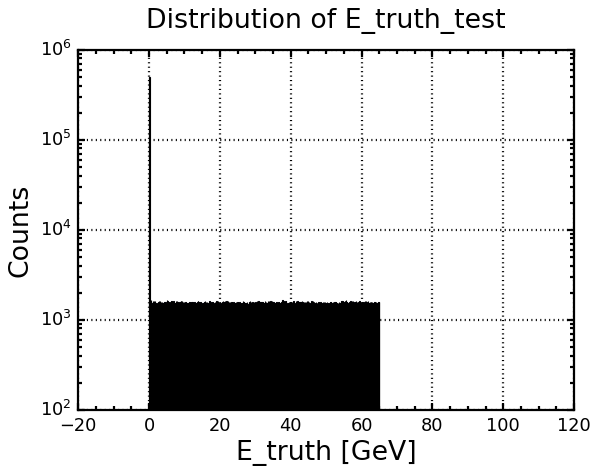

In [ ]:
#Draw E_truth
plt.figure(figsize=fig_size)
plt.hist(E_truth_uniform, bins=1000, range=(0, 100), edgecolor="black")
#plt.hist(E_truth_test, bins=20, range=(0, 1), edgecolor="black")
plt.xlabel("E_truth [GeV]")
plt.ylabel("Counts")
plt.yscale("log")
plt.title("Distribution of E_truth_test")
plt.grid(True)
plt.show()

In [ ]:
#zero suppression
def zero_suppression(E_layers, N_layers,E_truth):
    N_sum = np.array([np.sum(n) for n in N_layers])
    E_sum = np.array([np.sum(e) for e in E_layers])
    E_truth = np.array(E_truth)

    mask = N_sum > 0
    E_layers_filtered = [E_layers[i] for i in range(len(E_layers)) if mask[i]]
    N_layers_filtered = [N_layers[i] for i in range(len(N_layers)) if mask[i]]    
    E_truth_filtered = E_truth[mask]
    E_sum_filtered = E_sum[mask]
    N_sum_filtered = N_sum[mask]

    print("length after zero suppression:", len(E_layers_filtered), len(N_layers_filtered), len(E_sum_filtered), len(N_sum_filtered), len(E_truth_filtered))
    return E_layers_filtered, N_layers_filtered, E_sum_filtered, N_sum_filtered, E_truth_filtered

#Start from shower layer
def start_from_shower_layer(arr):
    N = len(arr)
    nonzero_idx = np.argmax(arr != 0)
    trimmed = arr[nonzero_idx:]
    if len(trimmed) < N:
        trimmed = np.pad(trimmed, (0, N - len(trimmed)), 'constant')
    return trimmed

def Event_Selection(E_layers,N_layers,E_truth):
    E_layers, N_layers, E_sum, N_sum, E_truth = zero_suppression(E_layers, N_layers, E_truth)
    E_layers = np.array([start_from_shower_layer(ev) for ev in E_layers])
    N_layers = np.array([start_from_shower_layer(ev) for ev in N_layers])
    return E_layers, N_layers, E_sum, N_sum, E_truth

#E_layers_train, N_layers_train, E_sum_train, N_sum_train, E_truth_train = Event_Selection(E_layers_train, N_layers_train, E_truth_train)
E_layers_uniform, N_layers_uniform, E_sum_uniform, N_sum_uniform, E_truth_uniform = Event_Selection(E_layers_uniform, N_layers_uniform, E_truth_uniform)
E_layers_test, N_layers_test, E_sum_test, N_sum_test, E_truth_test = Event_Selection(E_layers_test, N_layers_test, E_truth_test)

length after zero suppression: 1916297 1916297 1916297 1916297 1916297
length after zero suppression: 59990 59990 59990 59990 59990


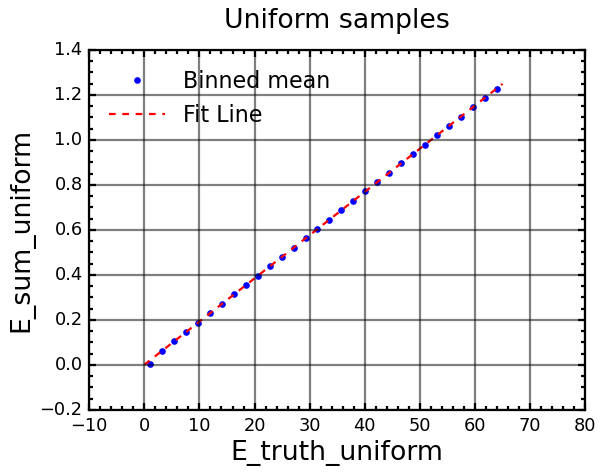

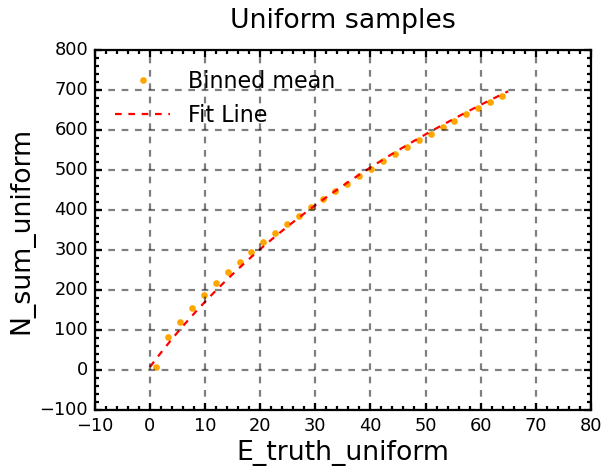

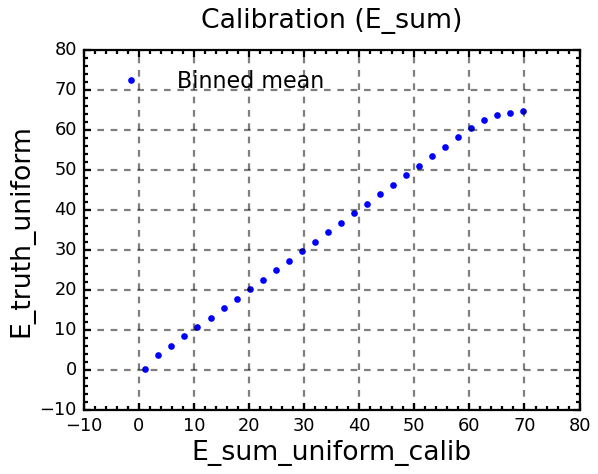

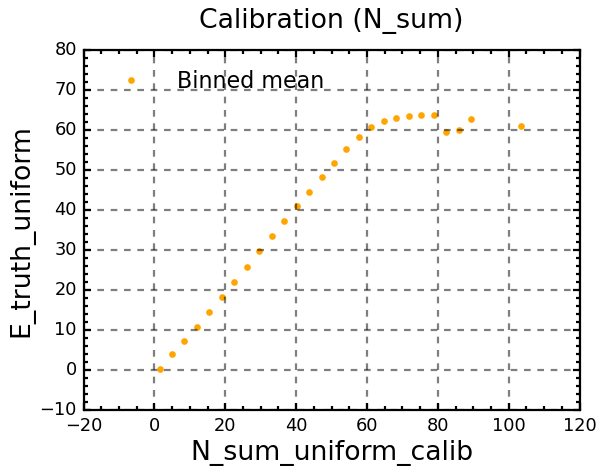

In [ ]:
def plot_binned(x, y, num_bins=30, color="blue", label=None):
    """Plot mean y in bins of x."""
    bin_means, bin_edges, _ = binned_statistic(x, y, statistic='mean', bins=num_bins)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    plt.plot(bin_centers, bin_means, marker="o", linestyle="None", color=color, label=label)

def exp_func(x, a, b, c):
    return a * np.exp(b * x) + c

fit_range = (0, 65)
mask_fit = (E_truth_uniform > fit_range[0]) & (E_truth_uniform < fit_range[1])
# E_sum: linear
coeffs_calibE = np.polyfit(E_sum_uniform[mask_fit], E_truth_uniform[mask_fit], 1)
coeffs_calibE_inv = np.polyfit(E_truth_uniform[mask_fit], E_sum_uniform[mask_fit], 1)
E_fit_line = np.poly1d(coeffs_calibE_inv)
# N_sum: exponential
coeffs_calibN, _ = curve_fit(exp_func, N_sum_uniform[mask_fit], E_truth_uniform[mask_fit], p0=(1,0.01,1))
E_fit = exp_func(N_sum_uniform, *coeffs_calibN)
interp_inv = interp1d(E_fit, N_sum_uniform, bounds_error=False, fill_value="extrapolate")

plt.figure(figsize=fig_size)
plot_binned(E_truth_uniform, E_sum_uniform, color="blue", label="Binned mean")
X_line=np.linspace(fit_range[0], fit_range[1], 200)
plt.plot(X_line, E_fit_line(X_line), color="red", linestyle="--", label="Fit Line")
plt.ylabel("E_sum_uniform")
plt.xlabel("E_truth_uniform")
plt.title("Uniform samples")
plt.grid(True, linestyle="-", alpha=0.5)
plt.legend(loc="upper left")

plt.figure(figsize=fig_size)
plot_binned(E_truth_uniform, N_sum_uniform, color="orange", label="Binned mean")
E_vals = np.linspace(fit_range[0], fit_range[1], 200)
N_vals = interp_inv(E_vals)  # 用反函数得到 N_sum 对应的拟合值
plt.plot(E_vals, N_vals, color="red", linestyle="--", label="Fit Line")
plt.ylabel("N_sum_uniform")
plt.xlabel("E_truth_uniform")
plt.title("Uniform samples")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(loc="upper left")

E_calib = np.poly1d(coeffs_calibE)
E_sum_uniform_calib = E_calib(E_sum_uniform)
#E_sum_train_calib   = E_calib(E_sum_train)
E_sum_test_calib    = E_calib(E_sum_test)
N_sum_uniform_calib = exp_func(N_sum_uniform, *coeffs_calibN)
#N_sum_train_calib   = exp_func(N_sum_train, *coeffs_calibN)
N_sum_test_calib    = exp_func(N_sum_test, *coeffs_calibN)

plt.figure(figsize=fig_size)
plot_binned(E_sum_uniform_calib,E_truth_uniform, color="blue", label="Binned mean")
plt.xlabel("E_sum_uniform_calib")
plt.ylabel("E_truth_uniform")
plt.title("Calibration (E_sum)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(loc="upper left")

plt.figure(figsize=fig_size)
plot_binned(N_sum_uniform_calib, E_truth_uniform, color="orange", label="Binned mean")
plt.xlabel("N_sum_uniform_calib")
plt.ylabel("E_truth_uniform")
plt.title("Calibration (N_sum)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(loc="upper left")
plt.show()

In [ ]:
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool  # 简单高效

# -----------------------
# 构造 Data (每个 event 一个 graph)
# -----------------------
def make_event_graph(energies, nhits):
    """
    energies: array-like shape (n_layers,)
    nhits:    array-like shape (n_layers,)
    返回: torch_geometric.data.Data
    """
    x = torch.tensor(
        list(zip(energies, nhits)), dtype=torch.float32
    )  # shape [n_nodes, 2]

    n = x.size(0)

    # 构造边：每层与相邻层互连（双向），也可改为全连接
    edge_index_list = []
    for i in range(n - 1):
        edge_index_list.append([i, i + 1])
        edge_index_list.append([i + 1, i])
    # 转为 tensor shape [2, n_edges]
    edge_index = torch.tensor(edge_index_list, dtype=torch.long).t().contiguous()

    # 可选：如果没有边（n==1），提供自环
    if edge_index.numel() == 0:
        edge_index = torch.tensor([[0],[0]], dtype=torch.long)

    # 目标：事件级真能量（scalar）
    # 这里 Data 要包含 y 字段用于回归训练
    # y 示例需外部提供（传入时覆盖）
    data = Data(x=x, edge_index=edge_index)
    return data

# -----------------------
# GNN model
# -----------------------
class ECALGNN(nn.Module):
    def __init__(self, in_channels=2, hidden=64, num_layers=3):
        """
        in_channels: 节点特征维度（energy, nhits -> 2）
        hidden: 隐层维度
        num_layers: GCN 层数
        输出：事件级标量回归
        """
        super().__init__()
        self.convs = nn.ModuleList()
        self.convs.append(GCNConv(in_channels, hidden))
        for _ in range(num_layers - 1):
            self.convs.append(GCNConv(hidden, hidden))

        # readout MLP：把 pooled node embedding 映射到输出
        self.readout = nn.Sequential(
            nn.Linear(hidden, hidden//2),
            nn.ReLU(),
            nn.Linear(hidden//2, 1)
        )

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        for conv in self.convs:
            x = conv(x, edge_index)
            x = F.relu(x)

        # 全局池化到事件级
        x = global_mean_pool(x, batch)  # shape [batch_size, hidden]

        out = self.readout(x).squeeze(-1)  # shape [batch_size]
        return out

# -----------------------
# 示例训练 / 推理流程
# -----------------------
def example_train_loop(list_of_events, y_array, epochs=20, batch_size=32, device='cpu'):
    """
    list_of_events: list of tuples (energies, nhits) each of shape (n_layers,)
    y_array: np.array 或 tensor shape (n_events,) 事件真实能量
    """
    device = torch.device(device)
    data_list = []
    for (energies, nhits), y in zip(list_of_events, y_array):
        d = make_event_graph(energies, nhits)
        d.y = torch.tensor([y], dtype=torch.float32)  # event-level target
        data_list.append(d)

    loader = DataLoader(data_list, batch_size=batch_size, shuffle=True)
    model = ECALGNN(in_channels=2, hidden=64, num_layers=3).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
    loss_fn = nn.MSELoss()

    model.train()
    for epoch in range(epochs):
        tot_loss = 0.0
        for batch in loader:
            batch = batch.to(device)
            opt.zero_grad()
            y_pred = model(batch)            # shape [batch_size]
            y_true = batch.y.view(-1).to(device)
            loss = loss_fn(y_pred, y_true)
            loss.backward()
            opt.step()
            tot_loss += loss.item() * y_true.size(0)
        print(f"Epoch {epoch:03d}  loss={tot_loss/len(data_list):.6f}")
    return model


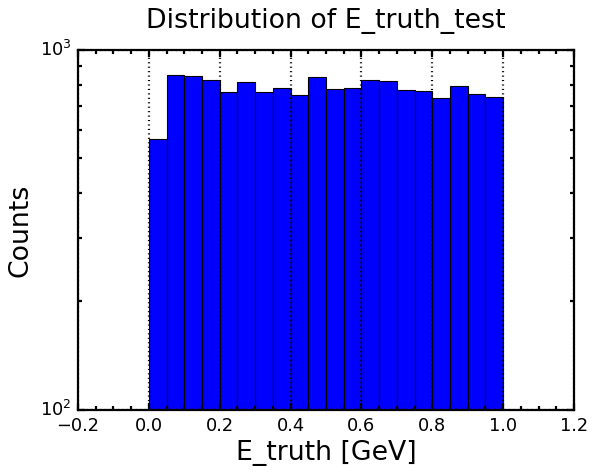

In [ ]:
X_train = np.hstack([E_layers_uniform, E_sum_uniform_calib[:,np.newaxis],N_layers_uniform, N_sum_uniform_calib[:,np.newaxis]])
X_test = np.hstack([E_layers_test, E_sum_test_calib[:,np.newaxis], N_layers_test, N_sum_test_calib[:,np.newaxis]])
y_train = E_truth_uniform
y_test = E_truth_test

E_cut=0.2
high_energy_mask = y_train > E_cut
low_energy_mask = y_train <= E_cut
N_high = len(y_train[high_energy_mask])
N_low_scale = int(N_high/(65-E_cut)*E_cut)
low_indices = np.where(low_energy_mask)[0]
low_indices_keep = np.random.choice(low_indices, N_low_scale, replace=False)
high_indices = np.where(high_energy_mask)[0]
indices_final = np.concatenate([low_indices_keep, high_indices])
X_train = X_train[indices_final]
y_train = y_train[indices_final]
#Draw E_truth
plt.figure(figsize=fig_size)
plt.hist(y_train, bins=20, range=(0, 1), edgecolor="black")
plt.xlabel("E_truth [GeV]")
plt.ylabel("Counts")
plt.yscale("log")
plt.title("Distribution of E_truth_test")
plt.grid(True)
plt.show()
#Scaling
random_state = 42
val_split = 0.2
X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, test_size=val_split, random_state=random_state)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_validate_scaled = scaler.transform(X_validate)

def plot_features_in_batches(X, feature_names=None, bins=50, n_cols=2, figsize=(12, 6)):
    n_features = X.shape[1]
    n_rows = (n_cols + n_cols - 1) // n_cols  # 每页只有 1 行 2 列的话 n_rows=1
    for start in range(0, n_features, n_cols):
        end = min(start + n_cols, n_features)
        plt.figure(figsize=figsize)
        for i, j in enumerate(range(start, end)):
            plt.subplot(1, n_cols, i + 1)
            plt.hist(X[:, j], bins=bins, color='skyblue', edgecolor='black')
            plt.yscale('log')
            if feature_names:
                plt.title(feature_names[j], fontsize=10)
            else:
                plt.title(f"Feature {j}", fontsize=10)
        plt.subplots_adjust(hspace=0.4, wspace=0.3)
        plt.show()
#plot_features_in_batches(X_train, bins=50, n_cols=2, figsize=(12, 6))

In [ ]:
ParameterScan=[5e-4,]#not used, but the loop is kept for future parameter scanning
Reco_hist_mlp_all = []
for lr in ParameterScan:
  mlp_model= train_mlp(X_train_scaled, y_train,X_validate_scaled, y_validate,
                    activation=nn.PReLU(),
                    hidden_dims=[128,64, 32],
                      dropout=0.1,
                      loss=HuberRelativeLoss(delta=0.1),
                      lr=lr,
                      batch_size=4096,
                      epochs=50,
                      patience=10,
                      random_state=random_state)
  device = next(mlp_model.parameters()).device
  torch.save(mlp_model, DataPath_Validate+f"/Models/MLP.pth")


Using device: cuda
Random state: 42
Training samples: 802547, Validation samples: 200637
learning rate: 0.0005, batch size: 4096, epochs: 50, patience: 10
Loss function: HuberRelativeLoss()
Hidden dims: [128, 64, 32], Dropout: 0.1, Activation: PReLU(num_parameters=1)
Epoch 001/50 | Train Loss: -935128.764724 | Val Loss: -5051330.602261| LR: 0.000200
Epoch 002/50 | Train Loss: -62297254680.257889 | Val Loss: -490301017795.521912| LR: 0.000300
Epoch 003/50 | Train Loss: -552039279656994.687500 | Val Loss: -5070406813995300.000000| LR: 0.000400


In [ ]:
def Combined_fit(x, y, fit_range=(0,65), plot=True, num_bins=100):
    # Step 1: Linear
    linear_range = (10,60)
    mask_lin = (x > linear_range[0]) & (x < linear_range[1])
    coeffs_lin = np.polyfit(x[mask_lin], y[mask_lin], 1)
    y_lin = np.poly1d(coeffs_lin)(x)
    residual = y - y_lin
    print("Step 1 Linear fit coeffs:", coeffs_lin)
    
    if plot:
        plt.figure(figsize=(5,4))
        plot_binned(x, y, num_bins=num_bins, color="blue", label="Data (bin mean)")
        plt.plot(x[mask_lin], y_lin[mask_lin], color="red", linestyle="--", label="Step1: Linear")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.title("Step 1: Linear Fit")
        plt.grid(True, linestyle="--", alpha=0.5)
        plt.show()
    
    # Step 2: exp fit
    fit_range = (3, 10)
    mask_fit = (x > fit_range[0]) & (x < fit_range[1])
    def fit_func2(x, a, b, c):
        return a * np.exp(b * x) + c
    coeff_fit2, _ = curve_fit(fit_func2, x[mask_fit], residual[mask_fit], p0=(1, -0.1, 0))
    x_fit2 = np.linspace(fit_range[0], fit_range[1], 200)
    y_fit2 = fit_func2(x_fit2, *coeff_fit2)
    if plot:
        plt.figure(figsize=(5,4))
        plot_binned(x, residual, num_bins=num_bins, color="blue", label="Residual (bin mean)")
        plt.plot(x_fit2, y_fit2, color="red", linestyle="-", label="Step2: exp Fit")
        plt.xlabel("x")
        plt.ylabel("Residual")
        plt.title("Step 2: exp Fit Residual")
        plt.grid(True, linestyle="--", alpha=0.5)
        plt.show()

    residual = y - fit_func2(x, *coeff_fit2)

    # Step 3: exp fit
    # if plot:
    #     plt.figure(figsize=(5,4))
    #     plot_binned(x, residual, num_bins=num_bins, color="blue", label="Residual (bin mean)")
    #     plt.xlabel("x")
    #     plt.ylabel("Residual")
    #     plt.title("Step 3: exp Fit Residual")
    #     plt.grid(True, linestyle="--", alpha=0.5)
    #     plt.show()
    # fit_range = (0, 30)
    # mask_fit = (x > fit_range[0]) & (x < fit_range[1])
    # def fit_func3(x, a, b, c):
    #     return a * np.exp(b * x) + c
    # coeff_fit3, _ = curve_fit(fit_func3, x[mask_fit], residual[mask_fit], p0=(1, -0.1, 0))
    # x_fit3 = np.linspace(fit_range[0], fit_range[1], 200)
    # y_fit3 = fit_func3(x_fit3, *coeff_fit3)
    # if plot:
    #     plt.plot(x_fit3, y_fit3, color="red", linestyle="-", label="Step3: exp Fit")

    # residual = y - fit_func2(x, *coeff_fit2) - fit_func3(x, *coeff_fit3)

    # Step 4: Linear again
    mask_fit = (x > fit_range[0]) & (x < fit_range[1])
    params_lin2 = np.polyfit(x[mask_fit], residual[mask_fit], 1)
    y_lin2 = np.poly1d(params_lin2)(x)
    print("Step 3 Linear fit coeffs:", params_lin2)
    
    if plot:
        plt.figure(figsize=(5,4))
        plot_binned(x, residual, num_bins=num_bins, color="blue", label="Residual after Step2 (bin mean)")
        plt.plot(x, y_lin2, color="red", linestyle="--", label="Step3: Linear Fit")
        plt.xlabel("x")
        plt.ylabel("Residual")
        plt.title("Step 3: Linear Fit Residual")
        plt.grid(True, linestyle="--", alpha=0.5)
        plt.show()
    
    # Final combined function
    def f(x_val):
        return ( 
                fit_func2(x_val, *coeff_fit2) + 
                #fit_func3(x_val, *coeff_fit3) + 
                np.poly1d(params_lin2)(x_val))
    return f
def build_reco_hist(y_pred, y_truth, Energy_test, Nbins=50):
    reco_hist = []
    for i_E, E_truth in enumerate(Energy_test):
        mask = (y_truth == E_truth)
        reco_energy = y_pred[mask]

        if len(reco_energy) == 0:
            print(f"No events found for E_truth = {E_truth} GeV, skipping.")
            continue

        mean = np.mean(reco_energy)
        rms = np.std(reco_energy)
        valid_mask = (reco_energy >= mean - 5*rms) & (reco_energy <= mean + 5*rms)

        filtered_data = reco_energy[valid_mask]
        counts, bin_edges = np.histogram(filtered_data, bins=Nbins)

        reco_hist.append({
            "E_truth": E_truth,
            "counts": counts,
            "bin_edges": bin_edges
        })
    return reco_hist

X_validate_tensor = torch.tensor(X_validate_scaled, dtype=torch.float32).to(device)
y_pred = mlp_model(X_validate_tensor).detach().cpu().numpy()
y_true = y_validate
X_test_scaled = scaler.transform(X_test)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
with torch.no_grad():
    y_pred_test_mlp = mlp_model(X_test_tensor).detach().cpu().numpy()
#Reco_hist_mlp_all.clear()
#Reco_hist_mlp = build_reco_hist(y_pred_test_mlp_calib, E_truth_test, Energy_test, Nbins=50)
#Reco_hist_mlp_all.append(Reco_hist_mlp)

fit_range = (0, 65) 
mask = y_pred>0
y_pred = y_pred[mask]
y_true = y_true[mask]
residual_E = (y_pred - y_true) / y_pred
E_calib_fit = Combined_fit(y_pred, residual_E, fit_range=fit_range, plot=True, num_bins=50)
x_fit = np.linspace(fit_range[0], fit_range[1], 200)
y_fit = E_calib_fit(x_fit)
plt.figure(figsize=fig_size)
plot_binned(y_pred, residual_E, num_bins=200, color="blue", label="Binned mean")
plot_binned(y_pred_test_mlp, (y_pred_test_mlp - y_test) / y_pred_test_mlp,num_bins=50, color="orange", label="Binned mean")
plt.plot(x_fit, y_fit, color='red', label='3rd-degree polynomial fit')
plt.xlabel("E_pred [GeV]")
plt.ylabel("(E_pred - E_true)/E_pred")
plt.title("Residual vs E_pred (3rd-degree polynomial fit)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.show()

y_pred_test_mlp_calib = y_pred_test_mlp*(1-E_calib_fit(y_pred_test_mlp))
Reco_hist_mlp_all.clear()
Reco_hist_mlp = build_reco_hist(y_pred_test_mlp_calib, E_truth_test, Energy_test, Nbins=50)
Reco_hist_mlp_all.append(Reco_hist_mlp)

plt.figure(figsize=fig_size)
plot_binned(y_test, y_pred_test_mlp, color="blue", label="test samples")
plot_binned(y_true, y_pred, color="green", label="validate samples")
plt.xlabel("E_truth [GeV]")
plt.ylabel("E_pred [GeV]")
plt.title("MLP Reconstructed Energy vs True Energy")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(loc="upper left")  
plt.show()


In [ ]:
def fit_gamma(x, norm, k, mu, theta):
    return norm * gamma_dist.pdf(x, k, loc=mu, scale=theta)

def fit_log_normal(x, norm, sigma, loc, scale):
    """Log-normal distribution with location parameter."""
    return norm * log_normal_dist.pdf(x, s=sigma, loc=loc, scale=scale)

def fit_gaussian(x, norm, resolution, mean):
    return norm * gaussian_dist.pdf(x, loc=mean, scale=mean * resolution)

def fit_all(type,E_truth,counts,bin_edges):
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    dx = bin_edges[1] - bin_edges[0]
    peak = bin_centers[np.argmax(counts)]
    mean = np.average(bin_centers, weights=counts)
    rms = np.sqrt(np.average((bin_centers - mean)**2, weights=counts))
    print(f"Mean: {mean}, Peak: {peak}, RMS: {rms}")
    plt.figure(figsize=fig_size)
    plt.bar(bin_centers, counts, width=bin_edges[1]-bin_edges[0], alpha=0.6, label="Data", color='blue')

    #Gamma Fit
    #theta = abs(mean - peak)
    #k = rms / np.sqrt(theta)
    #mu = E_truth
    theta = max(rms, 1e-6)
    k = max((mean - bin_edges[0]) / theta, 1e-3)
    mu = bin_edges[0] # or try mean - k*theta
    norm = counts.sum() * dx
    params_gamma_initial = [norm, k, mu, theta]
    lower_bounds = [norm*0.01, k*0.1-1, mu*0.1-1, theta*0.1]
    upper_bounds = [norm*6, k*10, mu*1.5+10, theta*10]
    print(f"Initial Gamma Fit Parameters: {params_gamma_initial}")
    print(f"Gamma Fit Bounds: lower {lower_bounds}, \n upper {upper_bounds}")
    params_gamma, cov_gamma = curve_fit(fit_gamma, bin_centers, counts, p0=params_gamma_initial, bounds=(lower_bounds, upper_bounds))
    print(f"Gamma Fit Parameters: {params_gamma}")
    x_fit_gamma = np.linspace(bin_edges[0], bin_edges[-1], 100)
    y_fit_gamma = fit_gamma(x_fit_gamma, *params_gamma)
    #calculate peak and resolution
    k,mu,theta = params_gamma[1], params_gamma[2], params_gamma[3]
    peak_gamma = (k-1) * theta + mu
    J = np.array([0,theta, 1.0, (k - 1.0)])
    peak_gamma_error = np.sqrt(J @ cov_gamma @ J)
    mean_gamma = k * theta + mu
    J = np.array([0,theta, 1.0, k])
    mean_gamma_error = np.sqrt(J @ cov_gamma @ J)
    #res
    res_gamma = np.sqrt(k) * theta / peak_gamma
    dr_dnorm = 0.0
    dr_dk = (0.5 / np.sqrt(k) * theta * peak_gamma - np.sqrt(k) * theta * (theta)) / (peak_gamma**2)
    dr_dmu = - np.sqrt(k) * theta / (peak_gamma**2)
    dr_dtheta = (np.sqrt(k) * peak_gamma - np.sqrt(k) * theta * (k - 1.0)) / (peak_gamma**2)
    J = np.array([dr_dnorm, dr_dk, dr_dmu, dr_dtheta])
    res_gamma_error = np.sqrt(J @ cov_gamma @ J)
    print(f"Gamma Fit Peak: {peak_gamma} ± {peak_gamma_error}, Mean: {mean_gamma} ± {mean_gamma_error}, Resolution: {res_gamma} ± {res_gamma_error}")
    if type == "E":
        plt.title(f"Deposited Energy {E_truth} GeV")
        plt.xlabel("Deposited Energy [MeV]")
        plt.ylabel("Counts")
    elif type == "N":
        plt.title(f"Number of Hits {E_truth} GeV")
        plt.xlabel("Number of Hits")
        plt.ylabel("Counts")
    elif type == "E_reco":
        plt.title(f"Reconstructed Energy {E_truth} GeV")
        plt.xlabel("Reconstructed Energy [GeV]")
        plt.ylabel("Counts")
    else:
        print("Unknown type")
        return 0
    plt.plot(x_fit_gamma, y_fit_gamma, 'r-', label="Gamma Fit")
    #plt.xlim(peak_gamma - 4*peak_gamma*res_gamma, peak_gamma + 8*peak_gamma*res_gamma)
    #plt.yscale("log")
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()
    return (mean_gamma, mean_gamma_error, peak_gamma, peak_gamma_error, res_gamma, res_gamma_error)


length of Reco_hist_mlp_all: 1
length of Reco_hist_mlp: 12
Mean: -4.951158909671522e-07, Peak: -5.40912196811405e-07, RMS: 4.755330022824091e-07
Initial Gamma Fit Parameters: [np.float64(0.003129209521262055), np.float64(0.9856870026714585), np.float32(-1.4808029e-06), 1e-06]
Gamma Fit Bounds: lower [np.float64(3.1292095212620555e-05), np.float64(-0.9014312997328542), np.float32(-1.0000001), 1e-07], 
 upper [np.float64(0.01877525712757233), np.float64(9.856870026714585), np.float32(9.999998), 9.999999999999999e-06]
Gamma Fit Parameters: [ 1.66482474e-03  1.44172219e+00 -5.99896112e-07  1.87405042e-07]
Gamma Fit Peak: -5.17115145965646e-07 ± 1.103678639411151e-05, Mean: -3.297101042468379e-07 ± 1.2695333541236605e-05, Resolution: -0.4351458082767736 ± 3.157276096872799


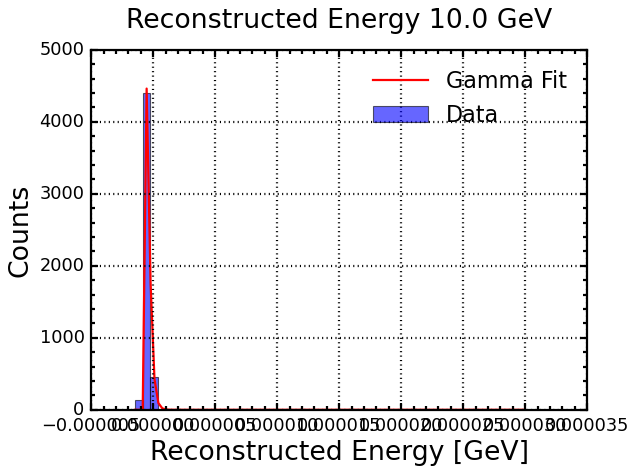

In [ ]:
#This cell is left here for debug
print("length of Reco_hist_mlp_all:", len(Reco_hist_mlp_all))
Reco_hist_mlp = Reco_hist_mlp_all[0] # Example for first beta
print("length of Reco_hist_mlp:", len(Reco_hist_mlp))
i_E = 6 # Example index, change as needed
#print(len(Reco_hist_mlp))
#print(Reco_hist_mlp[i_E])
mean_gamma,mean_gamma_error,peak_gamma,peak_gamma_error,res_gamma,res_gamma_error = fit_all(
    "E_reco",Reco_hist_mlp[i_E]["E_truth"],Reco_hist_mlp[i_E]["counts"],Reco_hist_mlp[i_E]["bin_edges"])

Mean: -4.622758228708035e-07, Peak: -4.51114033239719e-07, RMS: 4.616761482742641e-08
Initial Gamma Fit Parameters: [np.float64(3.6473967384154093e-05), np.float64(0.2567052047323459), np.float32(-7.18981e-07), 1e-06]
Gamma Fit Bounds: lower [np.float64(3.6473967384154095e-07), np.float64(-0.9743294795267654), np.float32(-1.0000001), 1e-07], 
 upper [np.float64(0.00021884380430492456), np.float64(2.5670520473234593), np.float32(9.999999), 9.999999999999999e-06]
Gamma Fit Parameters: [ 1.92527750e-04  9.73645588e-01 -6.87621988e-07  2.81161743e-06]
Gamma Fit Peak: -7.617205123941758e-07 ± 2.6434889869627222e-06, Mean: 2.0498969132554226e-06 ± 4.597877954784103e-05, Resolution: -3.6421768155490213 ± 50.083075269011196


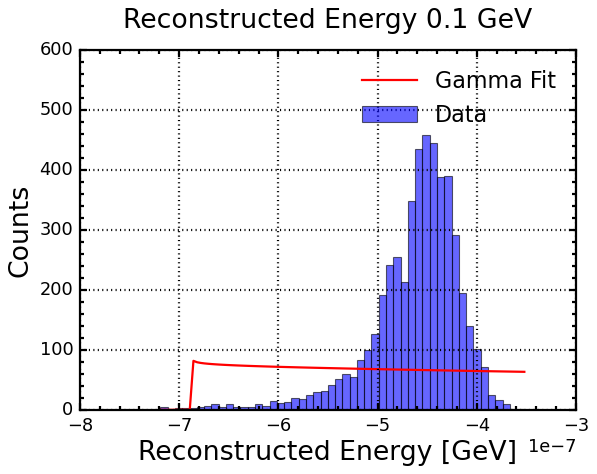

Mean: -4.7650902962478833e-07, Peak: -4.6901402583898744e-07, RMS: 5.3237207116838314e-08
Initial Gamma Fit Parameters: [np.float64(4.083881077576734e-05), np.float64(0.28345019126144216), np.float32(-7.599592e-07), 1e-06]
Gamma Fit Bounds: lower [np.float64(4.0838810775767344e-07), np.float64(-0.9716549808738558), np.float32(-1.0000001), 1e-07], 
 upper [np.float64(0.00024503286465460405), np.float64(2.8345019126144217), np.float32(9.999999), 9.999999999999999e-06]
Gamma Fit Parameters: [ 2.12730094e-04  1.07593934e+00 -6.29119262e-07  3.14493257e-06]
Gamma Fit Peak: -3.902951719171335e-07 ± 6.739958354274548e-06, Mean: 2.7546373932931393e-06 ± 0.00013703536829983828, Resolution: -8.358186380839623 ± 484.07682232930205


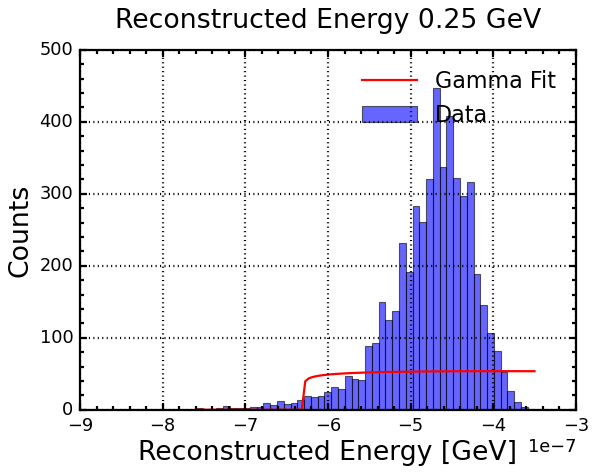

Mean: -4.957404788190805e-07, Peak: -4.945322871208191e-07, RMS: 6.474333659034255e-08
Initial Gamma Fit Parameters: [np.float64(5.024107082363116e-05), np.float64(0.3256860319917716), np.float32(-8.214265e-07), 1e-06]
Gamma Fit Bounds: lower [np.float64(5.024107082363116e-07), np.float64(-0.9674313968008228), np.float32(-1.0000001), 1e-07], 
 upper [np.float64(0.00030144642494178697), np.float64(3.256860319917716), np.float32(9.999999), 9.999999999999999e-06]
Gamma Fit Parameters: [ 2.12495478e-04  1.01731520e+00 -5.71761509e-07  1.01713133e-06]
Gamma Fit Peak: -5.541496783770428e-07 ± 2.2425364933542819e-07, Mean: 4.629816481984296e-07 ± 3.5337002450860536e-06, Resolution: -1.8513038790456673 ± 5.930300675651553


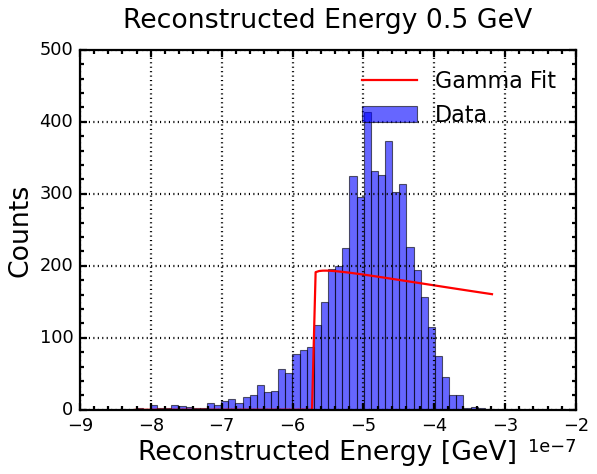

Mean: -5.100171491230096e-07, Peak: -4.857033673033584e-07, RMS: 8.440468088227394e-08
Initial Gamma Fit Parameters: [np.float64(7.225626859508338e-05), np.float64(0.5032618120586311), np.float32(-1.013279e-06), 1e-06]
Gamma Fit Bounds: lower [np.float64(7.225626859508339e-07), np.float64(-0.9496738187941369), np.float32(-1.0000001), 1e-07], 
 upper [np.float64(0.0004335376115705003), np.float64(5.032618120586311), np.float32(9.999998), 9.999999999999999e-06]
Gamma Fit Parameters: [ 8.59032416e-05  2.13911964e+00 -6.45856352e-07  1.00000000e-07]
Gamma Fit Peak: -5.319443878241728e-07 ± 1.0378841046253522e-08, Mean: -4.319443878241728e-07 ± 3.243360049485353e-08, Resolution: -0.27494846934162886 ± 0.05780082435913219


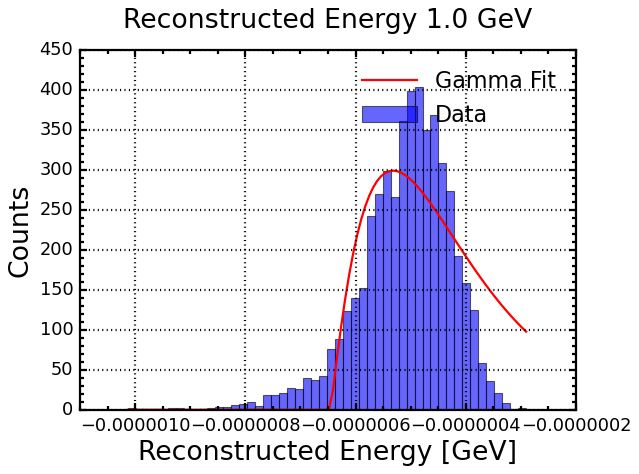

Mean: -5.076815495587101e-07, Peak: -4.4433397761167726e-07, RMS: 1.0101694467089878e-07
Initial Gamma Fit Parameters: [np.float64(8.65955631752513e-05), np.float64(0.568927346696783), np.float32(-1.0766089e-06), 1e-06]
Gamma Fit Bounds: lower [np.float64(8.65955631752513e-07), np.float64(-0.9431072653303217), np.float32(-1.0000001), 1e-07], 
 upper [np.float64(0.0005195733790515078), np.float64(5.68927346696783), np.float32(9.999998), 9.999999999999999e-06]
Gamma Fit Parameters: [ 9.67215072e-05  2.45641771e+00 -6.82329329e-07  1.00000000e-07]
Gamma Fit Peak: -5.366875577927872e-07 ± 9.554085420754238e-09, Mean: -4.3668755779278727e-07 ± 2.5790094583043276e-08, Resolution: -0.29203142204953536 ± 0.04370582800803974


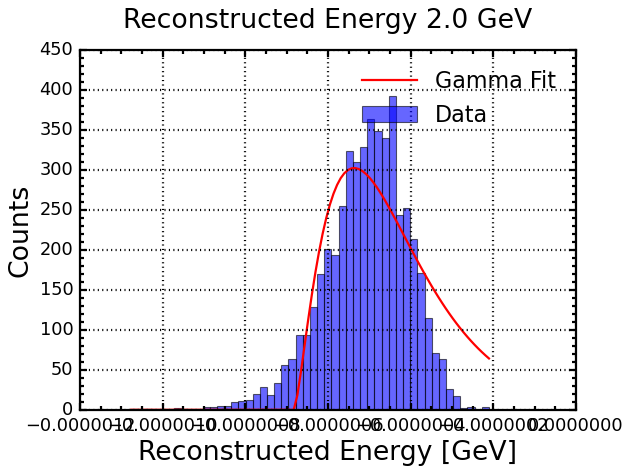

Mean: -4.962674057149724e-07, Peak: -5.612155291601084e-07, RMS: 3.8718206659778475e-07
Initial Gamma Fit Parameters: [np.float64(0.0019192367344658123), np.float64(18.69270292166235), np.float32(-1.918897e-05), 1e-06]
Gamma Fit Bounds: lower [np.float64(1.9192367344658122e-05), np.float64(0.869270292166235), np.float32(-1.0000019), 1e-07], 
 upper [np.float64(0.011515420406794874), np.float64(186.92702921662348), np.float32(9.999971), 9.999999999999999e-06]
Gamma Fit Parameters: [ 1.91923675e-03  1.86927029e+01 -1.74016704e-05  1.00000599e-06]
Gamma Fit Peak: 2.9113843492721894e-07 ± 9.806777653719625e-05, Mean: 1.2911444213312292e-06 ± 0.00015887726845889615, Resolution: 14.850432727508448 ± 4757.318340948819


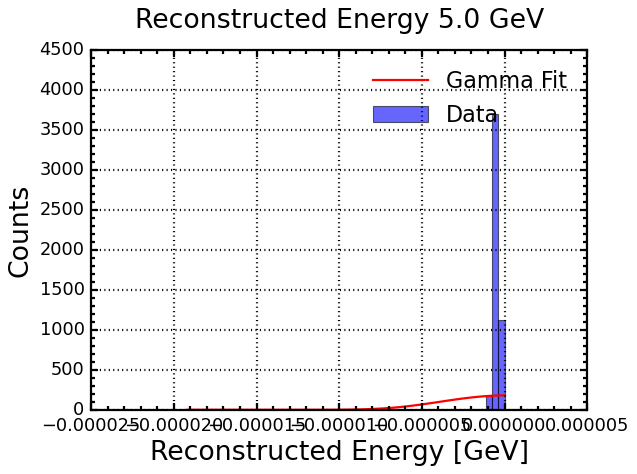

Mean: -4.951158909671522e-07, Peak: -5.40912196811405e-07, RMS: 4.755330022824091e-07
Initial Gamma Fit Parameters: [np.float64(0.003129209521262055), np.float64(0.9856870026714585), np.float32(-1.4808029e-06), 1e-06]
Gamma Fit Bounds: lower [np.float64(3.1292095212620555e-05), np.float64(-0.9014312997328542), np.float32(-1.0000001), 1e-07], 
 upper [np.float64(0.01877525712757233), np.float64(9.856870026714585), np.float32(9.999998), 9.999999999999999e-06]
Gamma Fit Parameters: [ 1.66482474e-03  1.44172219e+00 -5.99896112e-07  1.87405042e-07]
Gamma Fit Peak: -5.17115145965646e-07 ± 1.103678639411151e-05, Mean: -3.297101042468379e-07 ± 1.2695333541236605e-05, Resolution: -0.4351458082767736 ± 3.157276096872799


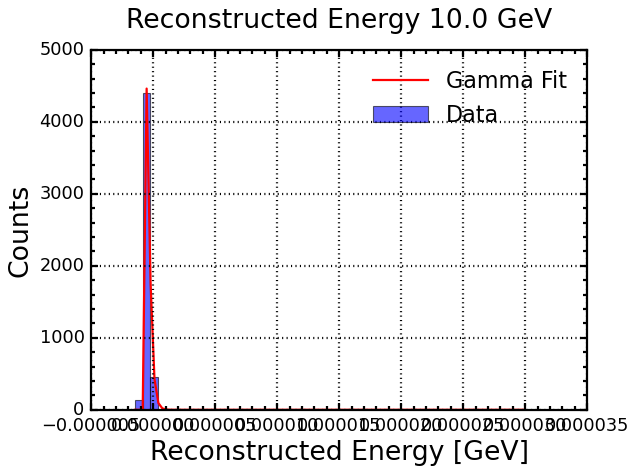

Mean: -1.2910929677248787e-06, Peak: -1.5392179193440825e-06, RMS: 2.093245533415523e-06
Initial Gamma Fit Parameters: [np.float64(0.013810702745104209), np.float64(40.46159724185605), np.float32(-8.598715e-05), np.float64(2.093245533415523e-06)]
Gamma Fit Bounds: lower [np.float64(0.0001381070274510421), np.float64(3.046159724185605), np.float32(-1.0000086), np.float64(2.0932455334155232e-07)], 
 upper [np.float64(0.08286421647062525), np.float64(404.6159724185605), np.float32(9.999871), np.float64(2.093245533415523e-05)]


RuntimeError: Optimal parameters not found: The maximum number of function evaluations is exceeded.

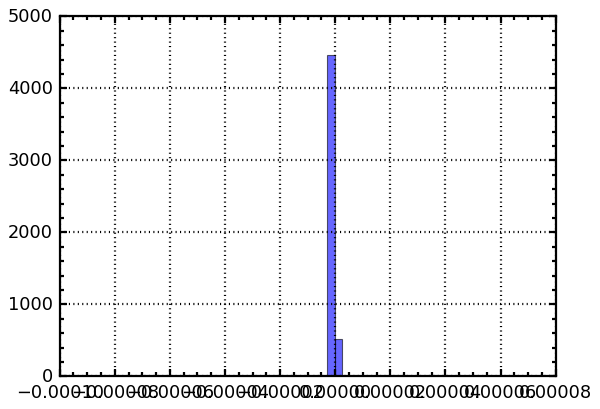

In [ ]:
#Fit RecoE and Save as CSV
#Gauss and LogNormal were not fitted but saved as 0 to keep format
def OutputCSV(Reco_hist, Energy_test, CSV_name):
    results = []
    for i_E in range(len(Energy_test)):
        mean_gauss,mean_gauss_error,peak_gauss, peak_gauss_error, res_gauss, res_gauss_error = 0, 0, 0, 0, 0, 0
        mean_log_normal,mean_log_normal_error,peak_log_normal, peak_log_normal_error, res_log_normal, res_log_normal_error = 0, 0, 0, 0, 0, 0
        mean_gamma,mean_gamma_error,peak_gamma, peak_gamma_error, res_gamma, res_gamma_error = fit_all("E_reco",Reco_hist[i_E]["E_truth"],Reco_hist[i_E]["counts"],Reco_hist[i_E]["bin_edges"])
        results.append({
            "ParticleEnergy": Energy_test[i_E],
            "Mean_Gauss": mean_gauss,
            "Mean_Gauss_Error": mean_gauss_error,
            "Peak_Gauss": peak_gauss,
            "Peak_Gauss_Error": peak_gauss_error,
            "Res_Gauss": res_gauss,
            "Res_Gauss_Error": res_gauss_error,
            "Mean_Gamma": mean_gamma,
            "Mean_Gamma_Error": mean_gamma_error,
            "Peak_Gamma": peak_gamma,
            "Peak_Gamma_Error": peak_gamma_error,
            "Res_Gamma": res_gamma,
            "Res_Gamma_Error": res_gamma_error,
            "Mean_LogNormal": mean_log_normal,
            "Mean_LogNormal_Error": mean_log_normal_error,
            "Peak_LogNormal": peak_log_normal,
            "Peak_LogNormal_Error": peak_log_normal_error,
            "Res_LogNormal": res_log_normal,
            "Res_LogNormal_Error": res_log_normal_error
        })
    df = pd.DataFrame(results)
    df.to_csv(CSV_name, index=False)
for i_para, para in enumerate(ParameterScan):
    if i_para != 0:
        continue  # 
    outputfile_name = os.path.join(DataPath_Validate, f"Reco_Results/RecoE_MLP_LR{para:.0e}_Fit.csv")
    OutputCSV(Reco_hist_mlp_all[i_para], Energy_test, outputfile_name)
    print(f"Saved fit results to {outputfile_name}")